# 1. Importado de librerías necesarias:



In [1]:
from selenium import webdriver
import time
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd

## 2. Proceso de extracción, transformación y carga de data (Proceso de ETL)

### 2.1 Extracción de datos:

<br>

#### 2.1.1 Descargar de información Censo USA:

Para llevar a cabo el análisis, se descargó la tabla "2022:ACS 1-Year Estimates Subjects Tables" del Censo de Estados Unidos. Se seleccionó el año más reciente con el fin de obtener información actualizada.

In [53]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains

# Iniciar el navegador Chrome
driver = webdriver.Chrome()

# Abrir la página de Census Reporter
driver.get("https://censusreporter.org/")

# Esperar hasta que el enlace "data.census.gov" esté presente y hacer clic en él
data_census_link = WebDriverWait(driver, 30).until(
    EC.presence_of_element_located((By.PARTIAL_LINK_TEXT, "data.census.gov"))
)
data_census_link.click()

# Esperar hasta que el enlace "Tables" esté presente y hacer clic en él
tables_link = WebDriverWait(driver, 30).until(
    EC.presence_of_element_located((By.LINK_TEXT, "Tables"))
)
tables_link.click()

# Esperar hasta que el objeto con el id "sidePanel-result-S0101" esté presente
object_s0101 = WebDriverWait(driver, 30).until(
    EC.presence_of_element_located((By.ID, "sidePanel-result-S0101"))
)

# Encontrar el enlace correspondiente a las tablas S0101: Age and Sex y hacer clic en él
menu_link = object_s0101.find_element(By.CLASS_NAME, "block-link")
menu_link.click()

# Esperar hasta que el botón "More Tools" esté presente y sea clickeable
more_tools_button = WebDriverWait(driver, 30).until(
    EC.element_to_be_clickable((By.XPATH, "//div[@class='aqua-toolbar-button-label' and text()='More Tools']"))
)

# Desplazar hasta el elemento "More Tools" para asegurarse de que esté en la vista
actions = ActionChains(driver)
actions.move_to_element(more_tools_button).perform()

# Hacer clic en el botón "More Tools"
more_tools_button.click()

Ejecutado el script para obtener la informacón de las tablas se procedio a seleccionar el formato de descarga. Para el caso de estudio se seleccion archivo con extensión csv. A continuación detallo la tabla descargar

En este caso se seleccion las tablas de la sección:
- S0101:Age and Sex, de alli la tabla 2022: ACS 1-Year Estimates Subjects Tables


<br>

### 2.1.2 Descargar de información Personas sin seguro USA: 

Fue considerado el link proporcionado, y posterior obtencion de archivo ASPE Uninsured Estimates by State and Eligibity Group (xlsx, 134,93 KB)

In [95]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Iniciar el navegador Chrome
driver = webdriver.Chrome()

# Abrir la página de Census Reporter
driver.get("https://aspe.hhs.gov/reports/state-county-local-estimates-uninsured-population-prevalence-key-demographic-features")

# Encontrar y hacer clic en el enlace "data.census.gov"
sin_seguro_link = driver.find_element(By.PARTIAL_LINK_TEXT, "ASPE Uninsured Estimates by State and Eligibility Group (xlsx, 134.93 KB)")
sin_seguro_link.click()

In [96]:
import pandas as pd

# Ruta al archivo Excel
archivo_excel = "aspe-uninsured-estimates-by-state.xlsx"

# Nombre de la hoja que quieres extraer
nombre_hoja = 'All Uninsured (#)'

# Leer el archivo Excel y seleccionar la hoja específica
datos_excel = pd.read_excel(archivo_excel, sheet_name=nombre_hoja)

# Ruta para guardar el archivo CSV
archivo_csv = 'sin_seguro.csv'

# Guardar los datos de la hoja como un archivo CSV
datos_excel.to_csv(archivo_csv, index=False)


El archivo descargado presenta múltiples hojas de cálculo; sin embargo, solo se selecciona la titulada "All Uninsured (#)", que contiene todos los datos necesarios, se utiliza la biblioteca de pandas para leerlo extraer información necesaria para el requerimiento.

<br>


### 2.1.3 Descargar informacion de personas con COVID19 USA: 

Se empleo una página web del CDC. Siendo este un Departamento de Salud y Servicios Humanos de los Estados Unidos (HHS). En el contexto de la pandemia de COVID-19, el CDC ha sido una fuente líder de información y orientación sobre la enfermedad, incluyendo datos actualizados sobre casos, hospitalizaciones, vacunaciones, medidas de prevención y más. Su sitio web oficial es una fuente confiable para obtener información actualizada y basada en evidencia sobre COVID-19, tanto a nivel nacional como por estado en los Estados Unidos.

In [74]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Iniciar el navegador Chrome
chrome_options = Options()
driver = webdriver.Chrome(options=chrome_options)

# Abrir la página de Census Reporter
driver.get("https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm")

try:
    # Esperar hasta 30 segundos para que el elemento esté presente en la página
    enlace = WebDriverWait(driver, 30).until(
        EC.presence_of_element_located((By.XPATH, "//*[@id='firstLink']/ul/li[1]/a"))
    )

    # Una vez que el elemento esté presente, obtener la URL del enlace
    url_enlace = enlace.get_attribute('href')

    # Hacer clic en el enlace
    enlace.click()
except Exception as e:
    print("Error:", e)

### 2.2 Transformación:

<br>

Descargado los archivos .csv. A continuacion se realizarán adecuaciones de las tablas respecto a la información que se requiere:

<br>

### 2.2.1 Transformación del archivo de censo

In [254]:
import pandas as pd

# Reemplaza 'ruta/del/archivo' con la ubicación real de tu archivo CSV
ruta_archivo = 'ACSDP1Y2022.DP05-2024-02-02T120035.csv'

# Utiliza pandas para leer el archivo CSV
df_censo = pd.read_csv(ruta_archivo)

# Seleccionar solo las columnas que contienen '!!Estimate' o 'Label (Grouping)' en su nombre
columnas_a_considerar = [col for col in df_censo.columns if '!!Estimate' in col or 'Label (Grouping)' in col]

# Crear un nuevo DataFrame solo con las columnas seleccionadas
df_censo = df_censo[columnas_a_considerar]

# Eliminar la palabra '!!Estimate' de los nombres de las columnas
df_censo.columns = df_censo.columns.str.replace('!!Estimate', '')

# Transponer el DataFrame
df_censo = df_censo.transpose()

# Establecer la primera fila como nombres de las columnas y eliminar la columna de índices
df_censo.columns = df_censo.iloc[0]

# Eliminar la primera fila (ahora convertida en nombres de columnas)
df_censo = df_censo[1:]

# Eliminar espacios en blanco al principio de los nombres de las columnas
df_censo.columns = df_censo.columns.str.strip()


# Lista de columnas que deseas mantener
columnas_a_mantener = ['Total population', 'Male', 'Female', 'Under 5 years',
                       '5 to 9 years', '10 to 14 years', '15 to 19 years',
                       '20 to 24 years', '25 to 34 years', '35 to 44 years',
                       '45 to 54 years', '55 to 59 years', '60 to 64 years',
                       '65 to 74 years', '75 to 84 years', '85 years and over']

# Mantener solo las columnas seleccionadas
df_censo = df_censo[columnas_a_mantener]


# Eliminar las columnas duplicadas
df_censo = df_censo.loc[:,~df_censo.columns.duplicated()]

# Lista de columnas a convertir a tipo numérico
columnas_a_convertir = ['Total population', 'Male', 'Female', 'Under 5 years',
                        '5 to 9 years', '10 to 14 years', '15 to 19 years',
                        '20 to 24 years', '25 to 34 years', '35 to 44 years',
                        '45 to 54 years', '55 to 59 years', '60 to 64 years',
                        '65 to 74 years', '75 to 84 years', '85 years and over']

# Reemplazar comas por nada en las columnas a convertir
df_censo[columnas_a_convertir] = df_censo[columnas_a_convertir].replace(',', '', regex=True)

# Convertir las columnas a tipo numérico
df_censo[columnas_a_convertir] = df_censo[columnas_a_convertir].apply(pd.to_numeric)

# Creas la nueva columna '19 to 64' sumando las columnas especificadas
df_censo['19 to 64'] = df_censo['20 to 24 years'] + df_censo['25 to 34 years'] + df_censo['35 to 44 years'] + df_censo['45 to 54 years'] + df_censo['55 to 59 years'] + df_censo['60 to 64 years']

# Utiliza el método drop para eliminar las columnas especificadas
df_censo.drop(columns=['20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years','65 to 74 years','75 to 84 years','85 years and over'], inplace=True)

# Calcula el porcentaje y asigna el resultado a una nueva columna llamada 'Percentage'
df_censo['Percentage'] = (df_censo['19 to 64'] / df_censo['Total population']) * 100

# Convierte el resultado a tipo de datos entero para eliminar los decimales
df_censo['Percentage'] = df_censo['Percentage'].astype(int)

# Crear una nueva columna llamada 'state' con los datos de 'Label (Grouping)'
df_censo['state'] = df_censo.index

# Guardar el DataFrame como un archivo CSV
df_censo.to_csv('censo.csv', index=False)

### 2.2.2 Transformación del archivo de sin seguro

In [94]:
import pandas as pd

# Reemplaza con la ubicación real de tu archivo CSV
ruta_archivo = 'sin_seguro.csv'

# Utiliza pandas para leer el archivo CSV sin establecer ningún índice
df_sin_seguro = pd.read_csv(ruta_archivo, index_col=False)

# Seleccionar las columnas deseadas
columnas_a_mantener = ['State Name', 'Uninsured Population (Excluding Undocumented)']

# Mantener solo las columnas seleccionadas
df_sin_seguro = df_sin_seguro[columnas_a_mantener]

# Guardar el DataFrame como un archivo CSV
df_sin_seguro.to_csv('sin_seguro_t.csv', index=False)

### 2.2.3 Transformación del archivo de covid19-eu

In [110]:
import pandas as pd

# Reemplaza con la ubicación real de tu archivo CSV
ruta_archivo = 'Excess_Deaths_Associated_with_COVID-19.csv'

# Utiliza pandas para leer el archivo CSV sin establecer ningún índice
df_covid19_eu = pd.read_csv(ruta_archivo, index_col=False)

# Lista de columnas que deseas mantener
columnas_a_mantener = ['Week Ending Date', 'State', 'Observed Number']

# Mantener solo las columnas seleccionadas
df_covid19_eu = df_covid19_eu[columnas_a_mantener]


# Convertir la columna "Week Ending Date" a formato datetime
df_covid19_eu['Week Ending Date'] = pd.to_datetime(df_covid19_eu['Week Ending Date'])

# Extraer el año y crear la nueva columna "anio"
df_covid19_eu['anio'] = df_covid19_eu['Week Ending Date'].dt.year


# Crear un nuevo DataFrame agrupando por "State" y "anio" y sumando la columna "Observed Number"
df_suma_estado_anio = df_covid19_eu.groupby(['State', 'anio'])['Observed Number'].sum().reset_index()

# Filtrar el DataFrame para que solo contenga información del año 2020
df_suma_estado_anio = df_suma_estado_anio[df_suma_estado_anio['anio'] == 2020]

# Guardar el DataFrame como un archivo CSV
df_suma_estado_anio.to_csv('covid19.csv', index=False)

### 3. Análisis exploratorio de los datos (EDA)

   Total population      Male    Female  Under 5 years  5 to 9 years  \
0           5074296   2461248   2613048         284064        311592   
1            733583    385667    347916          46497         49637   
2           7359197   3678381   3680816         393413        438358   
3           3045637   1504488   1541149         177765        196453   
4          39029342  19536425  19492917        2118386       2285436   

   10 to 14 years  15 to 19 years  19 to 64  Percentage       state  
0          318523          340067   2907037          57     Alabama  
1           51178           44794    440003          59      Alaska  
2          463552          487734   4194186          56     Arizona  
3          200389          203500   1728688          56    Arkansas  
4         2550172         2568788  23347658          59  California  

Estadísticas descriptivas:
       Total population          Male        Female  Under 5 years  \
count      5.200000e+01  5.200000e+01  5.200000e+

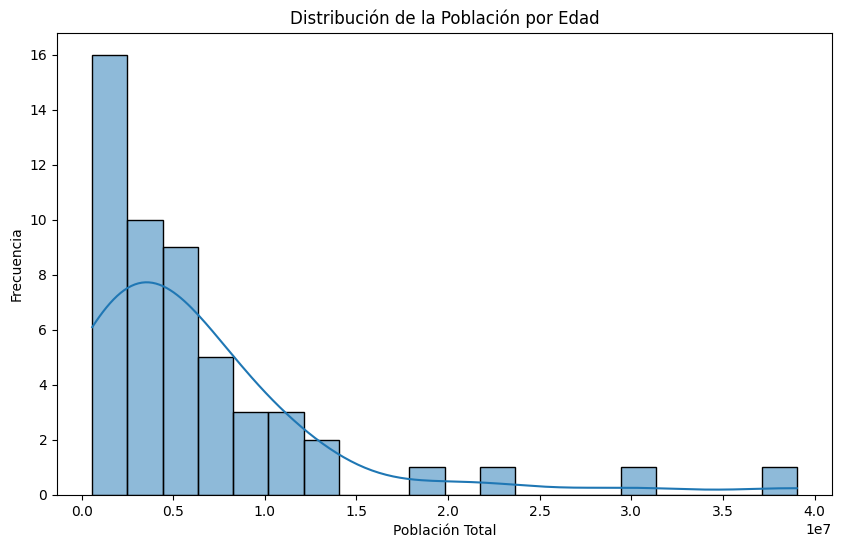

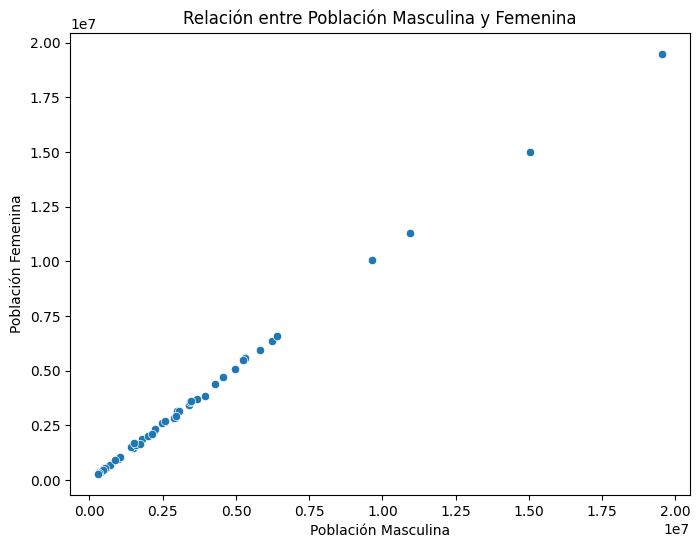

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
df_censo = pd.read_csv('censo.csv')

# Visualizar las primeras filas del DataFrame
print(df_censo.head())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df_censo.describe())

# Gráfico de histograma para la distribución de la población por edad
plt.figure(figsize=(10, 6))
sns.histplot(df_censo['Total population'], bins=20, kde=True)
plt.title('Distribución de la Población por Edad')
plt.xlabel('Población Total')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de dispersión entre la población masculina y femenina
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_censo, x='Male', y='Female')
plt.title('Relación entre Población Masculina y Femenina')
plt.xlabel('Población Masculina')
plt.ylabel('Población Femenina')
plt.show()
